In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
#Necessary Libraries and other set up
import pandas as pd
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns
print("Setup Complete")



Setup Complete


In [18]:
medical_insurance_path =  'insurance.csv'
medical_insurance_data = pd.read_csv(medical_insurance_path) 
medical_insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


It seems that the data does not have unnecessary columns. However, based on the first five entrees, the charges per patient seems extremely inconsistent. This can be seen with index 0 and 1 where index 1's charge is over 9 times smaller than index 0's cost. The only notable difference is that index 0 smokes along with the lack of children which make the charges even more confusing. Why does index 0's cost over 9 times greater when the only pressing liability with them is that they smoke and they are slightly overweight? Compared to index 1, being an 18-year-old parent who is overweight.

First, let's get rid of any duplicate entrees and null entrees if they exist.

In [19]:
# Check for nulls before cleaning
print("Null values per column:")
print(medical_insurance_data.isnull().sum())
print(f"\nDuplicates: {medical_insurance_data.duplicated().sum()}")

# Remove nulls and duplicates
cleaned_df = medical_insurance_data.dropna().drop_duplicates()

print(f"\nOriginal shape: {medical_insurance_data.shape}")
print(f"Cleaned shape: {cleaned_df.shape}")
print(f"Removed {medical_insurance_data.shape[0] - cleaned_df.shape[0]} rows")

# Display first few rows
print("\nCleaned data preview:")
print(cleaned_df.head())

Null values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Duplicates: 1

Original shape: (1338, 7)
Cleaned shape: (1337, 7)
Removed 1 rows

Cleaned data preview:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


**Fig. 1**

<Axes: xlabel='region', ylabel='count'>

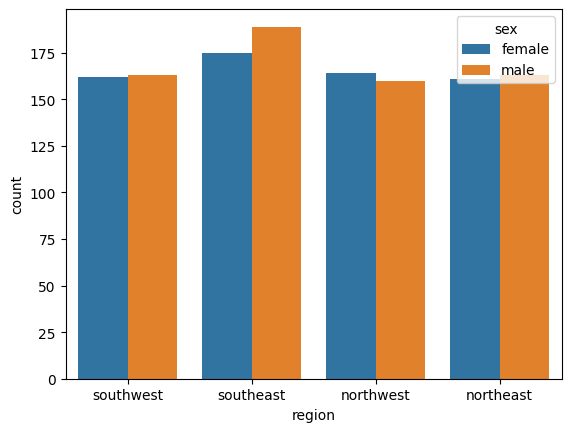

In [20]:
sns.countplot(data=cleaned_df, x='region' , hue='sex'  )

**Fig 2.**

<Axes: xlabel='smoker', ylabel='charges'>

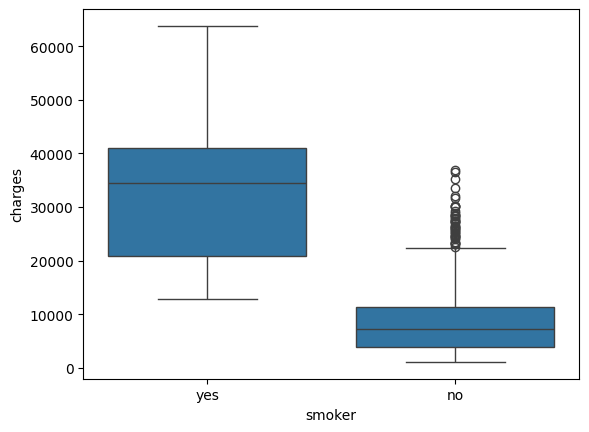

In [21]:
sns.boxplot(x='smoker', y='charges', data=cleaned_df)



**Fig 3.**

<Axes: xlabel='age', ylabel='charges'>

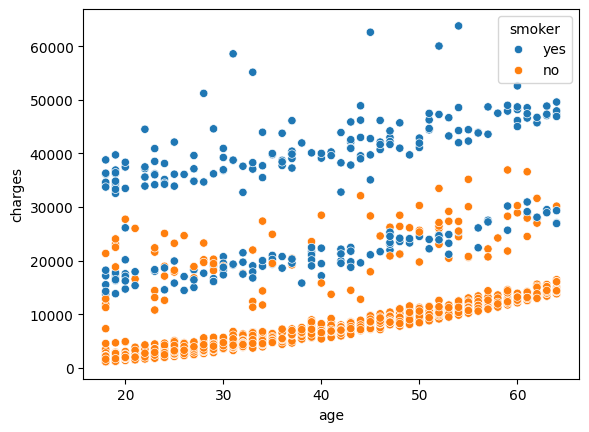

In [22]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=cleaned_df)



**Fig 4.**

<Axes: xlabel='bmi', ylabel='charges'>

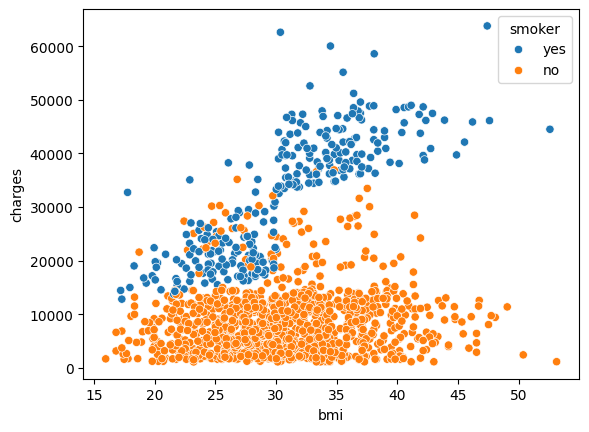

In [23]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=cleaned_df)

**Fig 5.**

<Axes: xlabel='children', ylabel='charges'>

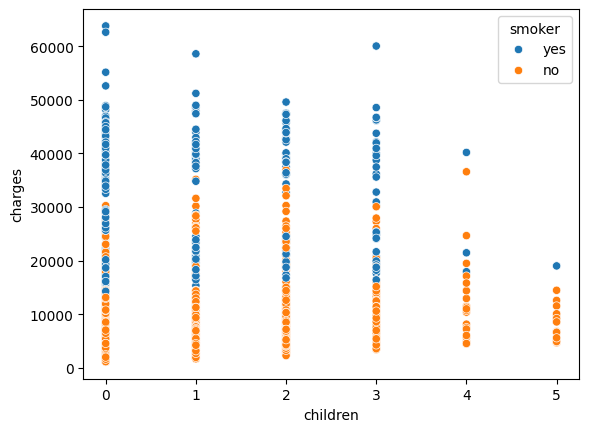

In [24]:
sns.scatterplot(x='children', y='charges', hue='smoker', data=cleaned_df)

**Fig 6.**

<Axes: xlabel='sex', ylabel='charges'>

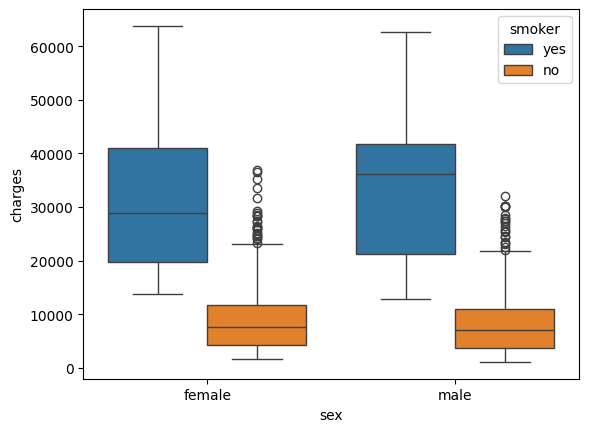

In [25]:
sns.boxplot(x='sex', y='charges', hue = 'smoker',data=cleaned_df)


An exploratory analysis was conducted on the medical insurance dataset to identify key factors influencing insurance charges. The dataset includes variables such as age, sex, BMI, number of children, smoking status, region, and insurance charges.

Key Findings


1. **Impact of Smoking on Insurance Charges**
A clear and significant correlation was observed between smoking status and insurance charges. Box plots comparing charges for smokers and non-smokers revealed that smokers incur substantially higher medical costs. This suggests that smoking is a strong predictor of increased insurance premiums, likely due to its association with higher health risks and medical interventions.
2. **Sex and Insurance Charges**
Analysis of charges by sex indicated no significant difference in medical costs between male and female policyholders. This suggests that insurance pricing, at least in this dataset, does not exhibit gender-based bias.
3. **Effect of Age on Charges**
A scatter plot of age versus charges shows a positive correlation, indicating that insurance costs tend to increase with age. This trend aligns with the general understanding that older individuals are more likely to require medical services, thus incurring higher insurance expenses.
4. **BMI and Insurance Costs**
Similarly, a positive relationship was identified between BMI and insurance charges. Individuals with higher BMI, particularly those classified as obese, tend to face increased medical costs. This may reflect the higher risk of chronic conditions associated with elevated BMI levels.


**Conclusion**:
Overall, the analysis demonstrates that **smoking**, **age**, and **BMI** are the most influential factors driving insurance charges. Meanwhile, sex and region appear to have minimal impact on cost variability. These insights are crucial for understanding how health behaviors and demographics affect medical insurance pricing and can inform both policy design and individual decision-making.

Knowing that **smoking**, **age**, and **BMI** are the most influential factors driving insurance charges, lets predict the price of a customer's insurance.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- STEP 1: PREPROCESSING (Making data machine-readable) ---
df_model = cleaned_df.copy()

# 1. Turn "sex" and "smoker" into 0s and 1s
le = LabelEncoder()
df_model['sex'] = le.fit_transform(df_model['sex'])       # male/female -> 1/0
df_model['smoker'] = le.fit_transform(df_model['smoker']) # yes/no -> 1/0

# 2. Turn "region" into separate columns (One-Hot Encoding)
# This creates columns like 'region_southwest', 'region_northwest', etc.
df_model = pd.get_dummies(df_model, columns=['region'], drop_first=True)

# Check what the computer sees now
print("New Data Format:")
print(df_model.head())

# --- STEP 2: THE SPLIT (Train vs Test) ---
# X = The data we use to predict (Age, BMI, Smoker, etc.)
# y = The answer we want to predict (Charges)
X = df_model.drop('charges', axis=1)
y = df_model['charges']

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

New Data Format:
   age  sex     bmi  children  smoker      charges  region_northwest  \
0   19    0  27.900         0       1  16884.92400             False   
1   18    1  33.770         1       0   1725.55230             False   
2   28    1  33.000         3       0   4449.46200             False   
3   33    1  22.705         0       0  21984.47061              True   
4   32    1  28.880         0       0   3866.85520              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  

Training Data Shape: (1069, 8)
Testing Data Shape: (268, 8)


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Initialize the model
lr_model = LinearRegression()

# 2. Train the model (The "Study" Phase)
# The model looks at X_train (Age, BMI, etc.) and learns to predict y_train (Charges)
lr_model.fit(X_train, y_train)

# 3. Make Predictions (The "Exam" Phase)
# We hide the real answers (y_test) and ask the model to guess based on X_test
y_pred_lr = lr_model.predict(X_test)

# 4. Grade the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"RMSE (Average Error): ${rmse:.2f}")
print(f"R² Score (Accuracy):  {r2:.4f}")

--- Linear Regression Results ---
RMSE (Average Error): $5956.34
R² Score (Accuracy):  0.8069


--- Random Forest Results ---
RMSE (Average Error): $4700.55
R² Score (Accuracy):  0.8798
Improvement over Linear: 0.0729


/tmp/ipykernel_3846/1124579474.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


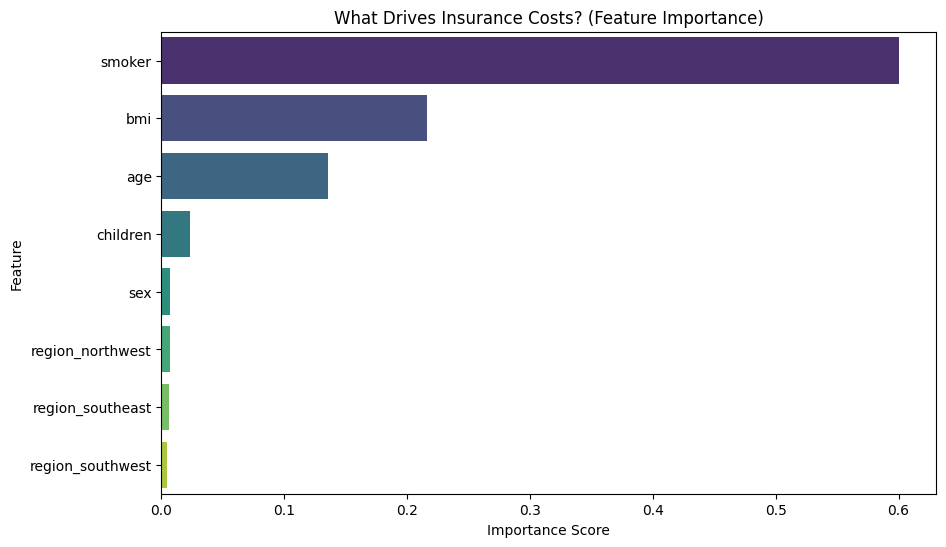

In [28]:
from sklearn.ensemble import RandomForestRegressor

# --- STEP 5: (Random Forest) ---
# 1. Initialize the model (n_estimators=100 means we build 100 trees)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Train the model
rf_model.fit(X_train, y_train)

# 3. Make Predictions
y_pred_rf = rf_model.predict(X_test)

# 4. Grade the Model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Results ---")
print(f"RMSE (Average Error): ${rmse_rf:.2f}")
print(f"R² Score (Accuracy):  {r2_rf:.4f}")
print(f"Improvement over Linear: {r2_rf - 0.8069:.4f}")

# --- STEP 6: FEATURE IMPORTANCE (The Business Insight) ---
# What actually drives the price? Let's ask the model.
import matplotlib.pyplot as plt
import seaborn as sns

# Get importance scores
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for plotting
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('What Drives Insurance Costs? (Feature Importance)')
plt.xlabel('Importance Score')
plt.show()

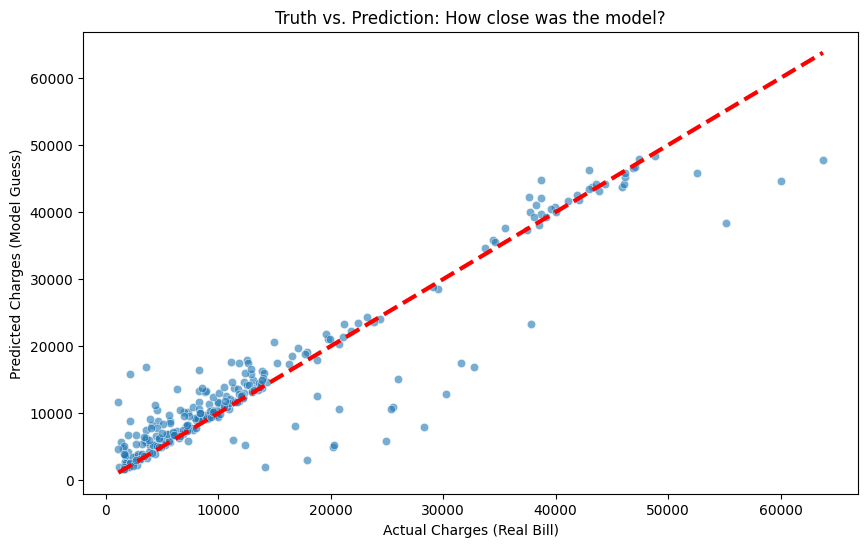

In [29]:
# --- STEP 7: VISUALIZE PERFORMANCE ---
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)

# A red line representing "Perfect Prediction"
# If a dot is on this line, the prediction was 100% correct
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)

plt.xlabel('Actual Charges (Real Bill)')
plt.ylabel('Predicted Charges (Model Guess)')
plt.title('Truth vs. Prediction: How close was the model?')
plt.show()

Insurance Cost Predictor

In [30]:
import pandas as pd

def predict_my_cost(age, sex, bmi, children, smoker, region):
    """
    Takes raw user input, processes it, and returns the predicted cost.
    """
    
    # 1. Create a dictionary with the raw data
    input_data = {
        'age': [age],
        'bmi': [bmi],
        'children': [children],
        'sex': [1 if sex.lower() == 'male' else 0],        # Manual Label Encoding
        'smoker': [1 if smoker.lower() == 'yes' else 0],   # Manual Label Encoding
    }
    
    # 2. Handle the "Region" (One-Hot Encoding trick)
    # The model expects columns like 'region_northwest', 'region_southeast', etc.
    # We set them all to 0 initially.
    regions = ['region_northwest', 'region_southeast', 'region_southwest']
    
    for r in regions:
        # If the user's region matches the column name, set it to 1, else 0
        # Example: if input is 'southwest', 'region_southwest' becomes 1
        input_data[r] = [1 if region.lower() in r else 0]

    # 3. Convert to DataFrame
    input_df = pd.DataFrame(input_data)
    
    # 4. Ensure column order matches the training data EXACTLY
    # (This prevents errors if columns are in the wrong order)
    # We use X.columns from your previous step
    final_df = input_df[X.columns]
    
    # 5. Predict!
    prediction = rf_model.predict(final_df)[0]
    
    return prediction

# --- TEST IT OUT ---
# Change these values to whatever you want
my_cost = predict_my_cost(
    age=30,
    sex='male',
    bmi=25.5,
    children=0,
    smoker='no',      
    region='southwest'
)

print(f"Estimated Insurance Bill for no smoker: ${my_cost:,.2f}")

my_cost2 = predict_my_cost(
    age=30,
    sex='male',
    bmi=25.5,
    children=0,
    smoker='yes',      
    region='southwest'
)
print(f"Estimated Insurance Bill for yes smoker: ${my_cost2:,.2f}")




Estimated Insurance Bill for no smoker: $3,144.04
Estimated Insurance Bill for yes smoker: $18,333.30


In [31]:
import pickle
# Replace 'rf_model' with the name of your trained model variable
with open('insurance_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)